In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [49]:
class Piece:

    def __init__(self, points):
        self.orientations = set()
        o_prime = Orientation(points)
        self.add_all_orientations(o_prime)
        self.orientations = sorted(self.orientations)

    def add_all_orientations(self, o_prime):
        corners = o_prime.get_corner_points()
        for corner in corners:
            orientation = self.shift_orientation(o_prime, corner)
            self.add_rotations(orientation)

    def shift_orientation(self, orientation, corner_point):
        c_prime = Point(-1, -1)
        diff = c_prime - corner_point
        return Orientation([diff + p for p in orientation.points])

    def add_rotations(self, orientation):
        for transform in self.gen_transforms():
            orientation = Orientation(tuple([transform(point) for point in orientation.points]))
            if orientation.is_valid():
                self.orientations.add(orientation)

    def gen_transforms(self):
        flips = [ident, flip]
        rots = [ident, rot90, rot180, rot270]
        for f, r in itertools.product(flips, rots):
            yield lambda x: f(r(x))

    def get_orientation_prime(self):
        for o in self.orientations:
            # will just return the first one
            return o

    def __eq__(self, other):
        if len(self.orientations) != len(other.orientations):
            return False
        for o in self.orientations:
            if o not in other.orientations:
                return False
        return True

    def __ne__(self, other):
        return not self == other

    def __str__(self):
        return "\n".join([str(o) for o in self.orientations])

# Testing

def test_piece_equals():
    p1 = Piece([Point(0, 0), Point(0, 1)])
    p2 = Piece([Point(0, 1), Point(0, 0)])
    assert(p1 == p2)

    p1 = Piece([Point(0, 0), Point(0, 2)])
    p2 = Piece([Point(0, 1), Point(0, 0)])
    assert(p1 != p2)

def test_get_border_points():
    p1 = Piece([Point(0, 0), Point(0, 1)])
    o1 = next(p1.orientations.__iter__())

    expected = {Point(a, b) for a, b in [(-1, 1), (0, -1), (-1, 0), (0, 2), (1, 0), (1, 1)]}
    print(o1.get_border_points())
    assert(expected == o1.get_border_points())


def test_get_corner_points():
    p1 = Piece([Point(0, 0), Point(0, 1)])
    o1 = next(p1.orientations.__iter__())
    
    expected = {Point(a, b) for a, b in [(1, 2), (-1, 2), (1, -1)]}
    assert{expected == o1.get_corner_points()}

def test_all():
    test_piece_equals()
    test_get_border_points()
    test_get_corner_points()
    
test_all()

{(1, 2), (2, 3), (3, 3), (4, 2), (3, 1), (2, 1)}


AssertionError: 

## Visualization

In [ ]:
class PieceVisualization:
    EMPTY = 0
    FULL = 1
    BORDER = 2
    PLAYABLE = 3
    START = 4
    
    def __init__(self):
        pass
    
    def fill(self, point, value):
        x, y = self.get_indices(point)
        self.matrix[x, y] = value
        
    def get_indices(self, point):
        return point.x + 5, point.y + 5
    
    def display(self, orientation):
        self.init_matrix()
        self.fill_in_points(orientation)
        self.gen_graph()

    def init_matrix(self):
        self.x = [str(x) for x in range(-5, 6)]
        self.y = [str(x) for x in range(-5, 6)]
        matrix = []
        for x in self.x:
            sub = [self.EMPTY for y in self.y]
            matrix.append(sub)
        self.matrix = np.matrix(matrix)

    def fill_in_points(self, orientation):
        for p in orientation.points:
            self.fill(p, self.FULL)

        for p in orientation.get_corner_points():
            self.fill(p, self.PLAYABLE)
        
        for p in orientation.get_border_points():
            self.fill(p, self.BORDER)
            
        self.fill(Point(-1, -1), self.START)

    def gen_graph(self):
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.set_aspect('equal')
        plt.imshow(self.matrix)
        plt.show()

## Sandbox

In [40]:
p1 = Piece([Point(0, 0)])
p2 = Piece([Point(0, 0), Point(0, 1)])
p3 = Piece([Point(0, 0), Point(0, 1), Point(0, 2)])
p4 = Piece([Point(0, 0), Point(0, 1), Point(1, 1)])
p5 = Piece([Point(0, 0), Point(1, 0), Point(0, 1), Point(1, 1)])
p6 = Piece([Point(0, 0), Point(1, 0), Point(2, 0), Point(3, 0)])
p7 = Piece([Point(0, 0), Point(1, 0), Point(1, 1), Point(2, 1)])
p8 = Piece([Point(0, 0), Point(1, 0), Point(1, 1), Point(2, 0)])

NameError: name 'mod_points' is not defined

#### This doesnt account for all moves
Answer: just find shift between corner

A and B (all piars between Point(-1, -1) and Orientation.get_corners())

Shift and Use existing filp 


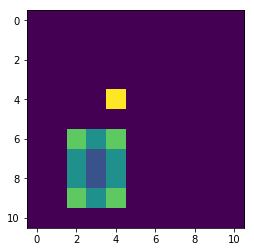

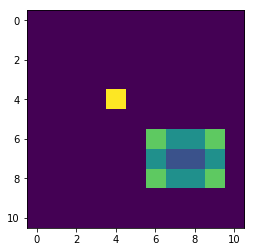

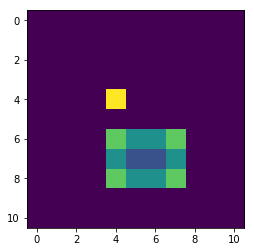

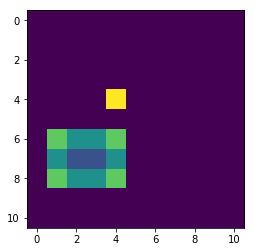

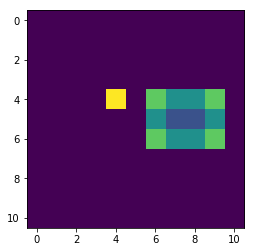

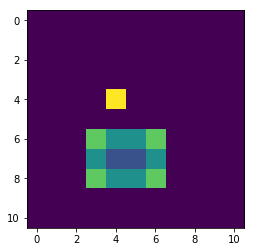

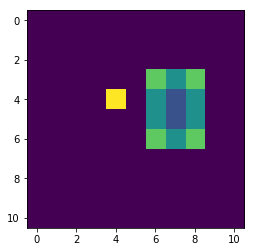

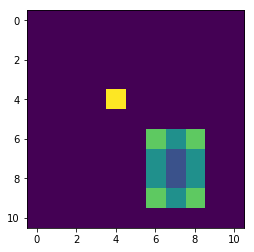

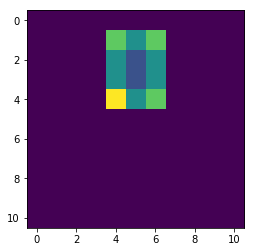

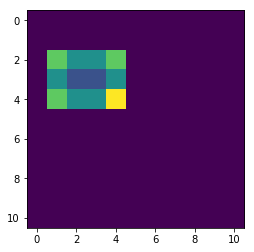

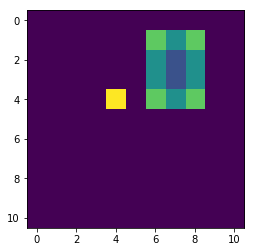

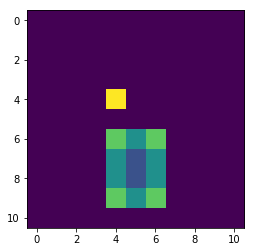

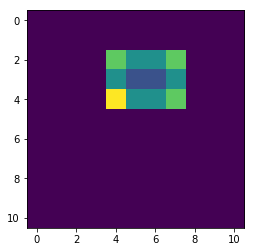

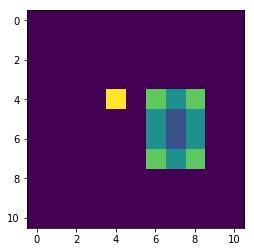

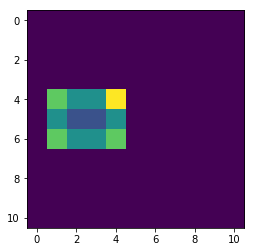

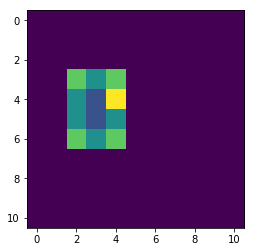

In [43]:
p = Piece([Point(0, 0), Point(0, 1)]) # , Point(1, 1), Point(1, 2), Point(2, 2)])
vis = PieceVisualization()
for o in p.orientations:
    vis.display(o)